In [3]:
from torch.distributions import constraints
import pyro.distributions as dist
from pyro.optim import Adam
import visualization as V
from pyro import poutine
import torch
import pyro
import os

In [18]:
# SAMPLING FROM A DISTRIBUTION
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
normal_sample = normal.rsample() # draw a sample from N(0,1)
print('Normal')
print("sample", normal_sample)
print("log prob", normal.log_prob(normal_sample)) # score the sample from N(0,1)
print("")


mvn = dist.MultivariateNormal(torch.ones((1,3)), torch.eye(3))
mvn_sample = mvn.sample()
print("Multivarite Normal")
print("sample", mvn_sample)
print("log prob", mvn.log_prob(mvn_sample)) # score the sample from N(0,1)


Normal
sample tensor(-0.2850)
log prob tensor(-0.9596)

Multivarite Normal
sample tensor([[1.1395, 0.8142, 2.4105]])
log prob tensor([-3.7786])


In [19]:
# DEFINING A JOINT PROBABILITY DISTRIBUTION
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('cloudy', 69.86683654785156)
('sunny', 55.220619201660156)
('sunny', 65.43292236328125)


In [20]:
# SIMPLE MODEL
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))


# CONDITIONING ON OBSERVED DATA
# Approach 1
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(9.5)})

# # Approach 2
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1.), obs=torch.tensor(9.5))


In [21]:
# POSITIVITY CONSTRAINTS
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs


In [22]:
# STOCHASTIC VARIATIONAL INFERENCE (SVI)
guess = 8.5

# SVI module with manually implemented variational family (guide)
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale, # generative model (can change this to scale_obs)
                     guide=scale_parametrized_guide, # variational family
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}), # optimizer
                     loss=pyro.infer.Trace_ELBO()) # loss function (ELBO for variational infererece)


# Running SVI in multiple iterations
losses, a, b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    # Record the current value of loss and run the optimization using "step"
    losses.append(svi.step(guess))
    
    # At each step record the current value of a and b
    a.append(pyro.param("a").item()) 
    b.append(pyro.param("b").item())


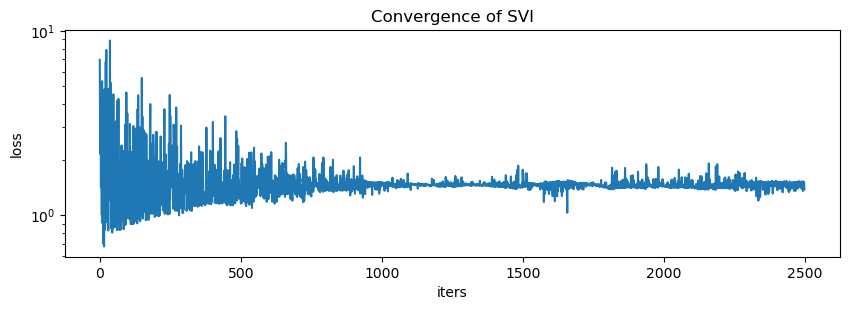

a =  9.099560737609863
b =  0.597242534160614


In [23]:
# PLOT RESULTS
V.plot_loss(losses)
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

In [24]:
# DEFAULT ADAM OPTIMIZER
adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

# CUSTOMIZED ADAM OPTIMIZER (different learning rate for each parameter)
def per_param_callable(module_name, param_name):
    if param_name == 'my_special_parameter':
        return {"lr": 0.010}
    else:
        return {"lr": 0.001}

optimizer = Adam(per_param_callable)